In [100]:
import zipfile
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Lambda
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
!pip install -q tensorflow
!pip install -q kaggle

# Download Dataset from Kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirreftekhari","key":"007f1e9b8402c00f15798df7811f4002"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 94% 311M/331M [00:02<00:00, 133MB/s]
100% 331M/331M [00:02<00:00, 129MB/s]


In [6]:
with zipfile.ZipFile("utkface-new.zip", 'r') as zip_ref:
  zip_ref.extractall("UTKFace")

print("Extracted files:", os.listdir("UTKFace"))

Extracted files: ['utkface_aligned_cropped', 'UTKFace', 'crop_part1']


# Load Dataset

In [31]:
dataset_path = '/content/UTKFace/UTKFace'
images64 = []
images32 = []
genders = []

for filename in os.listdir(dataset_path):
  img_path = os.path.join(dataset_path, filename)
  img = cv2.imread(img_path)

  img64 = cv2.resize(img, (64, 64)) # convert images to 64x64
  images64.append(img64)

  img32 = cv2.resize(img, (32, 32)) # convert images to 32x32
  images32.append(img32)

  gender = int(filename.split('_')[1])
  genders.append(gender)

images64 = np.array(images64) / 255.0
images32 = np.array(images32) / 255.0
genders = np.array(genders)
genders_oneHot = to_categorical(genders, num_classes=2)

In [34]:
print("Number of Images:", len(images64))
print("Length of Genders:", len(genders))

Number of Images: 23708
Length of Genders: 23708


# Split Data

In [35]:
x_train32, x_test32, y_train32, y_test32 = train_test_split(images32, genders_oneHot, test_size=0.25, random_state=42)
x_train64, x_test64, y_train64, y_test64 = train_test_split(images64, genders_oneHot, test_size=0.25, random_state=42)

In [36]:
print("Train Size:", len(x_train32))
print("Test Size:", len(x_test32))

Train Size: 17781
Test Size: 5927


# Sigmoid, ReLU, Softmax and Cross-Entropy loss from Scratch

In [22]:
def sigmoid(x):
  return 1 / (1 + tf.exp(-x))

In [23]:
def relu(x):
  return tf.maximum(0.0, x)

In [24]:
def softmax(x):
  exp_x = tf.exp(x - tf.reduce_max(x, axis=-1, keepdims=True))
  return exp_x / tf.reduce_sum(exp_x, axis=-1, keepdims=True)

In [42]:
def cross_entropy_loss(y_true, y_pred):
  y_pred = tf.clip_by_value(y_pred, 1e-12, 1.0)  # avoid log(0)
  loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
  return tf.reduce_mean(loss)

# Finding Best Image Size

In [56]:
model_oneHid = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation=relu),
    Dense(2, activation=softmax)
])

In [40]:
model_oneHid.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy']) # Learning rate is 0.001 (Adam default learning rate)
history32 = model_oneHid.fit(x_train32, y_train32, validation_data=(x_test32, y_test32), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6444 - loss: 0.6844 - val_accuracy: 0.7913 - val_loss: 0.4637
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8062 - loss: 0.4381 - val_accuracy: 0.8254 - val_loss: 0.4014
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8339 - loss: 0.3865 - val_accuracy: 0.8126 - val_loss: 0.4020
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8386 - loss: 0.3660 - val_accuracy: 0.8392 - val_loss: 0.3639
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8441 - loss: 0.3470 - val_accuracy: 0.8524 - val_loss: 0.3440
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8443 - loss: 0.3469 - val_accuracy: 0.8536 - val_loss: 0.3282
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8527 - loss: 0.3328 - val_accuracy: 0.8453 - val_loss: 0.3493
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8648 - loss: 0.3124 - val_accuracy: 0.

In [43]:
test_loss, test_accuracy = model_oneHid.evaluate(x_test32, y_test32)
print(f"Test Accuracy on One Hidden Layer Network with 32x32 images: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8558 - loss: 0.3097
Test Accuracy on One Hidden Layer Network with 32x32 images: 85.46%


In [45]:
model_oneHid = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(128, activation=relu),
    Dense(2, activation=softmax)
])

In [46]:
model_oneHid.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy']) # Learning rate is 0.001 (Adam default learning rate)
history64 = model_oneHid.fit(x_train64, y_train64, validation_data=(x_test64, y_test64), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6806 - loss: 0.9827 - val_accuracy: 0.6739 - val_loss: 0.6575
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8020 - loss: 0.4295 - val_accuracy: 0.8191 - val_loss: 0.4121
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8288 - loss: 0.3929 - val_accuracy: 0.8360 - val_loss: 0.3851
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8318 - loss: 0.3816 - val_accuracy: 0.8465 - val_loss: 0.3496
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8435 - loss: 0.3585 - val_accuracy: 0.8554 - val_loss: 0.3350
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8468 - loss: 0.3455 - val_accuracy: 0.7523 - val_loss: 0.5317
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8505 - loss: 0.3468 - val_accuracy: 0.8517 - val_loss: 0.3438
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8519 - loss: 0.3292 - val_accuracy: 0.

In [47]:
test_loss, test_accuracy = model_oneHid.evaluate(x_test64, y_test64)
print(f"Test Accuracy on One Hidden Layer Network with 64x64 images: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.3188
Test Accuracy on One Hidden Layer Network with 64x64 images: 85.02%


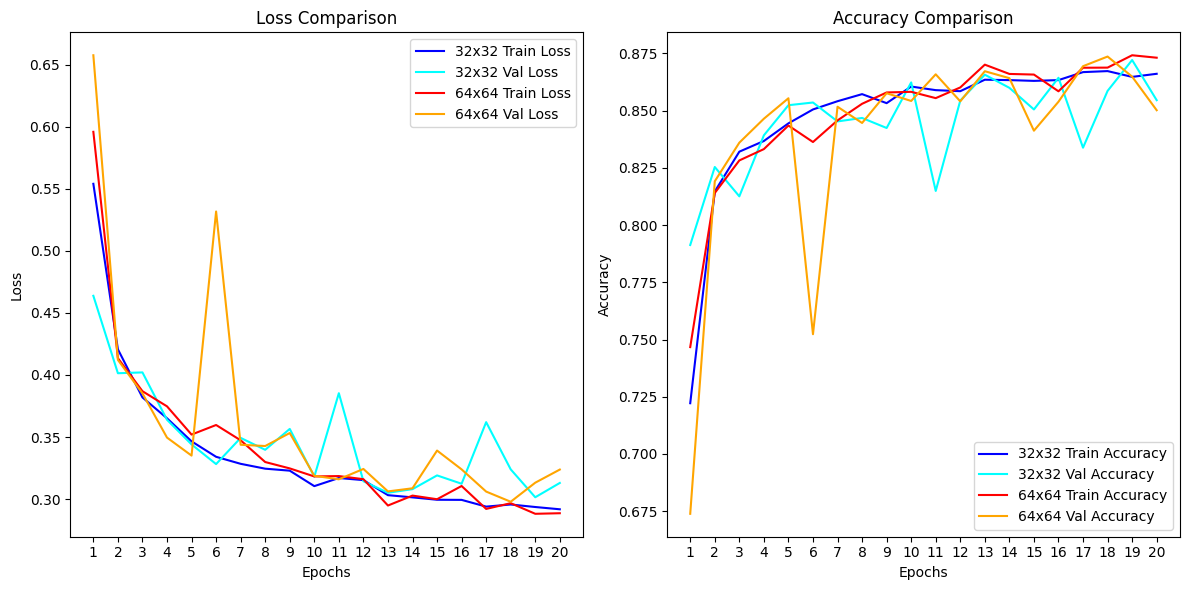

In [75]:
epochs = range(1, 21)

# Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history32.history['loss'], label='32x32 Train Loss', color='blue')
plt.plot(epochs, history32.history['val_loss'], label='32x32 Val Loss', color='cyan')
plt.plot(epochs, history64.history['loss'], label='64x64 Train Loss', color='red')
plt.plot(epochs, history64.history['val_loss'], label='64x64 Val Loss', color='orange')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history32.history['accuracy'], label='32x32 Train Accuracy', color='blue')
plt.plot(epochs, history32.history['val_accuracy'], label='32x32 Val Accuracy', color='cyan')
plt.plot(epochs, history64.history['accuracy'], label='64x64 Train Accuracy', color='red')
plt.plot(epochs, history64.history['val_accuracy'], label='64x64 Val Accuracy', color='orange')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)

plt.tight_layout()
plt.show()

### Therefore, the best image size is 32x32.

# Finding Best Hidden Layers

#### We saw the accuracy of one hidden layer network in previous part. now we check 2, 3 and 4 hidden layers.

### Two Hidden Layers:

In [53]:
model_twoHid = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(2, activation=softmax)
])

In [54]:
model_twoHid.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy'])
history32_2h = model_twoHid.fit(x_train32, y_train32, validation_data=(x_test32, y_test32), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6997 - loss: 0.5818 - val_accuracy: 0.8276 - val_loss: 0.3890
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8203 - loss: 0.4020 - val_accuracy: 0.8318 - val_loss: 0.3663
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8357 - loss: 0.3689 - val_accuracy: 0.7999 - val_loss: 0.4010
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8424 - loss: 0.3463 - val_accuracy: 0.8147 - val_loss: 0.3983
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8361 - loss: 0.3587 - val_accuracy: 0.8203 - val_loss: 0.3990
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8441 - loss: 0.3448 - val_accuracy: 0.8460 - val_loss: 0.3368
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8464 - loss: 0.3310 - val_accuracy: 0.8603 - val_loss: 0.3198
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8583 - loss: 0.3140 - val_accuracy: 0.

In [58]:
test_loss, test_accuracy = model_twoHid.evaluate(x_test32, y_test32)
print(f"Test Accuracy on Two Hidden Layers Network: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8439 - loss: 0.3804
Test Accuracy on Two Hidden Layers Network: 83.65%


### Three Hidden Layers:

In [60]:
model_threeHid = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(2, activation=softmax)
])

In [61]:
model_threeHid.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy'])
history32_3h = model_threeHid.fit(x_train32, y_train32, validation_data=(x_test32, y_test32), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6904 - loss: 0.6047 - val_accuracy: 0.7932 - val_loss: 0.4257
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8139 - loss: 0.4090 - val_accuracy: 0.8363 - val_loss: 0.3608
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8296 - loss: 0.3692 - val_accuracy: 0.8429 - val_loss: 0.3533
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8289 - loss: 0.3660 - val_accuracy: 0.8460 - val_loss: 0.3533
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8403 - loss: 0.3508 - val_accuracy: 0.8500 - val_loss: 0.3426
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8454 - loss: 0.3339 - val_accuracy: 0.8490 - val_loss: 0.3346
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8552 - loss: 0.3228 - val_accuracy: 0.8389 - val_loss: 0.3582
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8540 - loss: 0.3287 - val_accuracy: 0.

In [63]:
test_loss, test_accuracy = model_threeHid.evaluate(x_test32, y_test32)
print(f"Test Accuracy on Three Hidden Layers Network: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8641 - loss: 0.3036
Test Accuracy on Three Hidden Layers Network: 86.25%


### Four Hidden Layers:

In [64]:
model_fourHid = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(2, activation=softmax)
])

In [65]:
model_fourHid.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy'])
history32_4h = model_fourHid.fit(x_train32, y_train32, validation_data=(x_test32, y_test32), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7049 - loss: 0.5663 - val_accuracy: 0.8090 - val_loss: 0.4049
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8179 - loss: 0.3979 - val_accuracy: 0.8348 - val_loss: 0.3586
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8267 - loss: 0.3726 - val_accuracy: 0.8470 - val_loss: 0.3421
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8289 - loss: 0.3772 - val_accuracy: 0.8503 - val_loss: 0.3324
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8402 - loss: 0.3528 - val_accuracy: 0.8537 - val_loss: 0.3335
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8464 - loss: 0.3409 - val_accuracy: 0.8284 - val_loss: 0.3822
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8484 - loss: 0.3359 - val_accuracy: 0.8443 - val_loss: 0.3328
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8548 - loss: 0.3164 - val_accuracy: 0.

In [66]:
test_loss, test_accuracy = model_fourHid.evaluate(x_test32, y_test32)
print(f"Test Accuracy on Four Hidden Layers Network: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8502 - loss: 0.3285
Test Accuracy on Four Hidden Layers Network: 85.02%


### Compare:

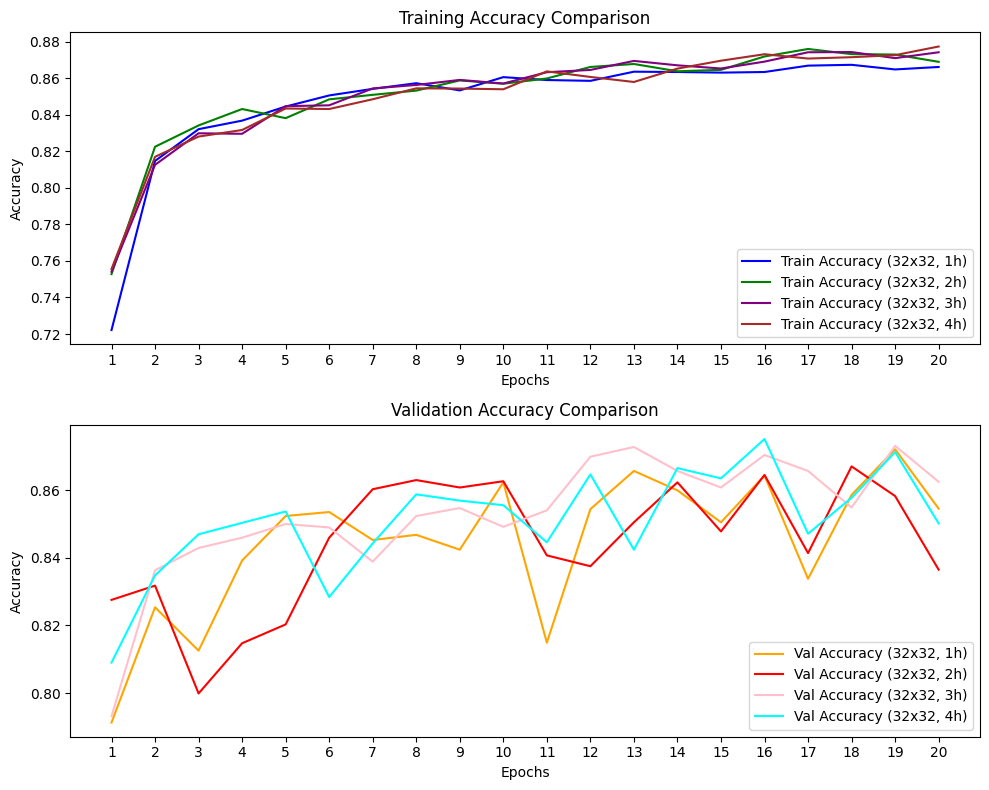

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Training Accuracy
axes[0].plot(epochs, history32.history['accuracy'], label='Train Accuracy (32x32, 1h)', color='blue')
axes[0].plot(epochs, history32_2h.history['accuracy'], label='Train Accuracy (32x32, 2h)', color='green')
axes[0].plot(epochs, history32_3h.history['accuracy'], label='Train Accuracy (32x32, 3h)', color='purple')
axes[0].plot(epochs, history32_4h.history['accuracy'], label='Train Accuracy (32x32, 4h)', color='brown')

axes[0].set_title('Training Accuracy Comparison')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Validation Accuracy
axes[1].plot(epochs, history32.history['val_accuracy'], label='Val Accuracy (32x32, 1h)', color='orange')
axes[1].plot(epochs, history32_2h.history['val_accuracy'], label='Val Accuracy (32x32, 2h)', color='red')
axes[1].plot(epochs, history32_3h.history['val_accuracy'], label='Val Accuracy (32x32, 3h)', color='pink')
axes[1].plot(epochs, history32_4h.history['val_accuracy'], label='Val Accuracy (32x32, 4h)', color='cyan')

axes[1].set_title('Validation Accuracy Comparison')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[0].set_xticks(range(1, 21))
axes[1].set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

### Therefore, the best number of hidden layers is 3.

# Finding Best Number of Neurons of Each Layer

We saw the same number of neurons for all layers in previous part (128 neurons). now we check other number of neurons.

In [77]:
# Descending number of neurons
model_threeHid_Desc = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(256, activation=relu),
    Dense(128, activation=relu),
    Dense(64, activation=relu),
    Dense(2, activation=softmax)
])

In [78]:
model_threeHid_Desc.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy'])
history32_3h_desc = model_threeHid_Desc.fit(x_train32, y_train32, validation_data=(x_test32, y_test32), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7015 - loss: 0.5886 - val_accuracy: 0.8281 - val_loss: 0.3861
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8049 - loss: 0.4239 - val_accuracy: 0.8228 - val_loss: 0.3764
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8281 - loss: 0.3728 - val_accuracy: 0.7751 - val_loss: 0.4433
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8335 - loss: 0.3674 - val_accuracy: 0.8500 - val_loss: 0.3324
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8465 - loss: 0.3327 - val_accuracy: 0.8380 - val_loss: 0.3545
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8529 - loss: 0.3284 - val_accuracy: 0.8434 - val_loss: 0.3473
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8409 - loss: 0.3438 - val_accuracy: 0.8468 - val_loss: 0.3466
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8447 - loss: 0.3383 - val_accuracy: 0

In [79]:
test_loss, test_accuracy = model_threeHid_Desc.evaluate(x_test32, y_test32)
print(f"Test Accuracy on Three Hidden Layers Network with Descendig Number of Neurons: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8757 - loss: 0.2857
Test Accuracy on Three Hidden Layers Network with Descendig Number of Neurons: 87.36%


In [81]:
# Ascending number of neurons
model_threeHid_Asc = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(64, activation=relu),
    Dense(128, activation=relu),
    Dense(256, activation=relu),
    Dense(2, activation=softmax)
])

In [82]:
model_threeHid_Asc.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy'])
history32_3h_asc = model_threeHid_Asc.fit(x_train32, y_train32, validation_data=(x_test32, y_test32), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7009 - loss: 0.5671 - val_accuracy: 0.8235 - val_loss: 0.3901
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8182 - loss: 0.3955 - val_accuracy: 0.8215 - val_loss: 0.4103
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8205 - loss: 0.3791 - val_accuracy: 0.8164 - val_loss: 0.3844
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8261 - loss: 0.3688 - val_accuracy: 0.8129 - val_loss: 0.3695
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8408 - loss: 0.3467 - val_accuracy: 0.8296 - val_loss: 0.3627
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8462 - loss: 0.3295 - val_accuracy: 0.8549 - val_loss: 0.3172
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8529 - loss: 0.3220 - val_accuracy: 0.8617 - val_loss: 0.3126
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8535 - loss: 0.3164 - val_accuracy: 

In [83]:
test_loss, test_accuracy = model_threeHid_Asc.evaluate(x_test32, y_test32)
print(f"Test Accuracy on Three Hidden Layers Network with Ascending Number of Neurons: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.3046
Test Accuracy on Three Hidden Layers Network with Ascending Number of Neurons: 86.89%


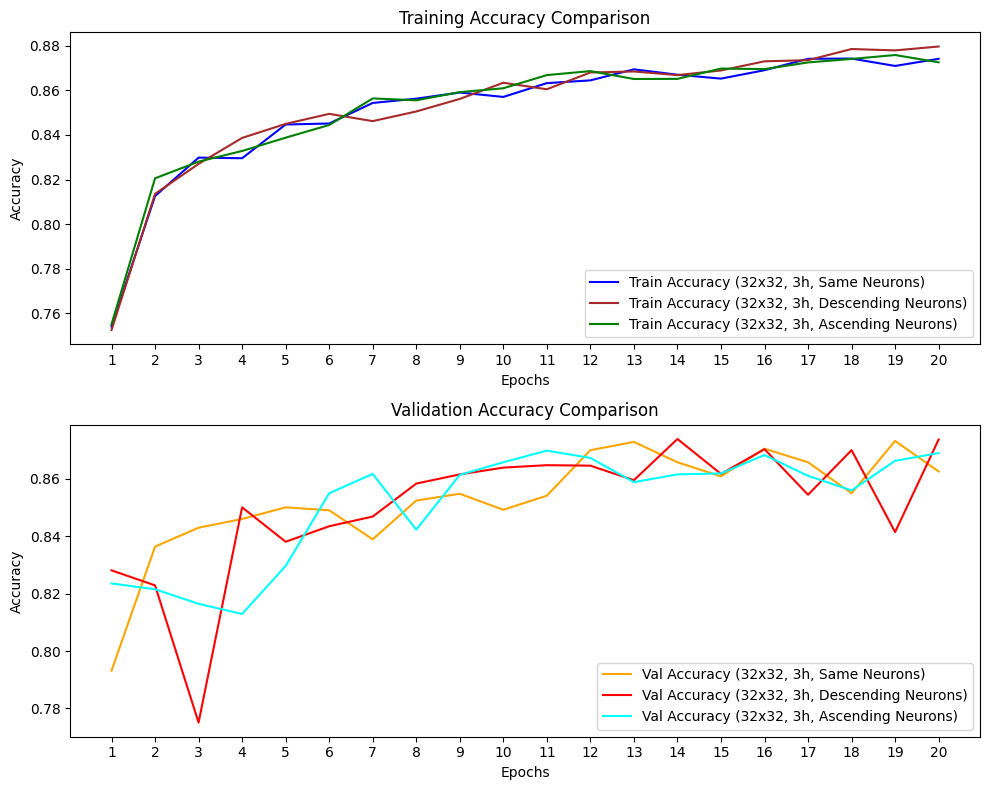

In [84]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Training Accuracy
axes[0].plot(epochs, history32_3h.history['accuracy'], label='Train Accuracy (32x32, 3h, Same Neurons)', color='blue')
axes[0].plot(epochs, history32_3h_desc.history['accuracy'], label='Train Accuracy (32x32, 3h, Descending Neurons)', color='brown')
axes[0].plot(epochs, history32_3h_asc.history['accuracy'], label='Train Accuracy (32x32, 3h, Ascending Neurons)', color='green')

axes[0].set_title('Training Accuracy Comparison')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Validation Accuracy
axes[1].plot(epochs, history32_3h.history['val_accuracy'], label='Val Accuracy (32x32, 3h, Same Neurons)', color='orange')
axes[1].plot(epochs, history32_3h_desc.history['val_accuracy'], label='Val Accuracy (32x32, 3h, Descending Neurons)', color='red')
axes[1].plot(epochs, history32_3h_asc.history['val_accuracy'], label='Val Accuracy (32x32, 3h, Ascending Neurons)', color='cyan')

axes[1].set_title('Validation Accuracy Comparison')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[0].set_xticks(range(1, 21))
axes[1].set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

### Therefore, Descending Number of Neurons is the best.
First Layer: 256

Second Layer: 128

Third Layer: 64

## Finally, the best network based on the results:

3 hidden layers.

Image input size 32x32.

Activation function in hidden layers: ReLU.

Activation function in output layer: Softmax.

Number of neurons as mentioned in previous cell.

# Compare one hidden layer vs. two hidden layers with different neurons

We saw the results of one hidden layer and two hidden layers with the same number of neurons (128 neurons) in Finding Best Hidden Layers part. now we check the different number of neurons.

In [96]:
model_2h = Sequential([
    Flatten(input_shape=(32, 32, 3)),
    Dense(128, activation=relu),
    Dense(64, activation=relu),
    Dense(2, activation=softmax)
])

In [93]:
model_2h.compile(optimizer='adam', loss=cross_entropy_loss, metrics=['accuracy'])
history32_2h_diffNe = model_2h.fit(x_train32, y_train32, validation_data=(x_test32, y_test32), epochs=20, batch_size=32)

Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7003 - loss: 0.5889 - val_accuracy: 0.8164 - val_loss: 0.4039
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8093 - loss: 0.4165 - val_accuracy: 0.8426 - val_loss: 0.3675
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8260 - loss: 0.3753 - val_accuracy: 0.8426 - val_loss: 0.3516
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8387 - loss: 0.3529 - val_accuracy: 0.8482 - val_loss: 0.3431
Epoch 5/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8405 - loss: 0.3515 - val_accuracy: 0.8343 - val_loss: 0.3706
Epoch 6/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8378 - loss: 0.3560 - val_accuracy: 0.8404 - val_loss: 0.3616
Epoch 7/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8474 - loss: 0.3337 - val_accuracy: 0.8404 - val_loss: 0.3356
Epoch 8/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8507 - loss: 0.3273 - val_accuracy: 0.

In [94]:
test_loss, test_accuracy = model_2h.evaluate(x_test32, y_test32)
print(f"Test Accuracy on Two Hidden Layers Network: {test_accuracy*100:.2f}%")

186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8593 - loss: 0.3053
Test Accuracy on Two Hidden Layers Network: 86.00%


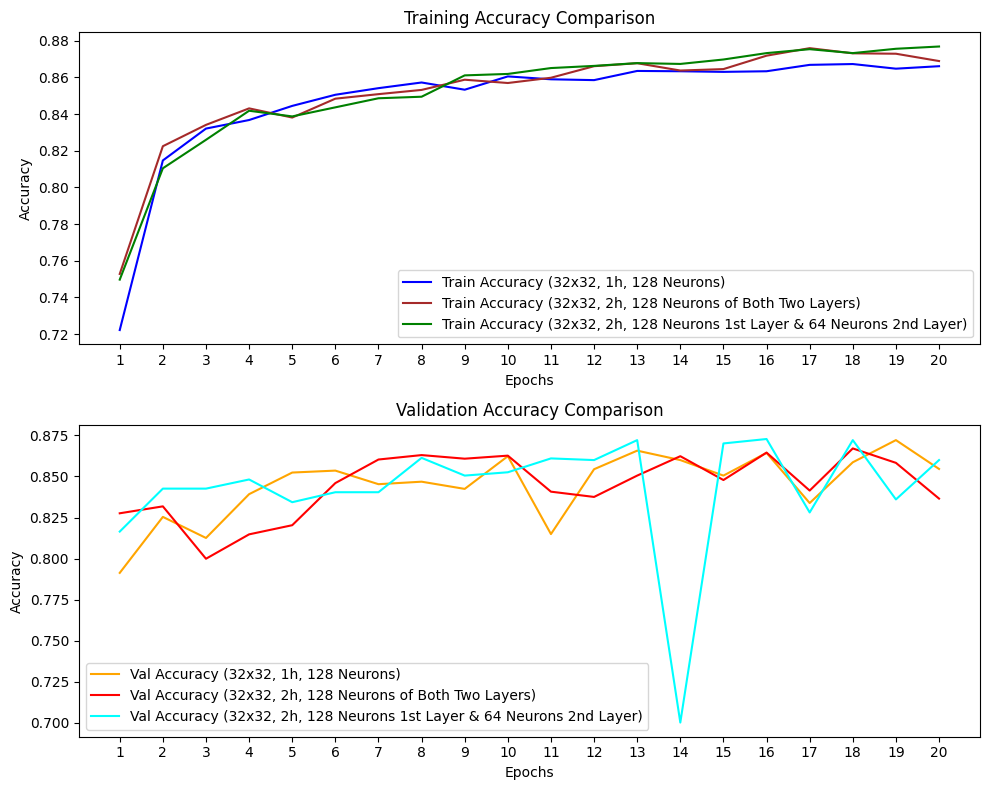

In [97]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Training Accuracy
axes[0].plot(epochs, history32.history['accuracy'], label='Train Accuracy (32x32, 1h, 128 Neurons)', color='blue')
axes[0].plot(epochs, history32_2h.history['accuracy'], label='Train Accuracy (32x32, 2h, 128 Neurons of Both Two Layers)', color='brown')
axes[0].plot(epochs, history32_2h_diffNe.history['accuracy'], label='Train Accuracy (32x32, 2h, 128 Neurons 1st Layer & 64 Neurons 2nd Layer)', color='green')

axes[0].set_title('Training Accuracy Comparison')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Validation Accuracy
axes[1].plot(epochs, history32.history['val_accuracy'], label='Val Accuracy (32x32, 1h, 128 Neurons)', color='orange')
axes[1].plot(epochs, history32_2h.history['val_accuracy'], label='Val Accuracy (32x32, 2h, 128 Neurons of Both Two Layers)', color='red')
axes[1].plot(epochs, history32_2h_diffNe.history['val_accuracy'], label='Val Accuracy (32x32, 2h, 128 Neurons 1st Layer & 64 Neurons 2nd Layer)', color='cyan')

axes[1].set_title('Validation Accuracy Comparison')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[0].set_xticks(range(1, 21))
axes[1].set_xticks(range(1, 21))

plt.tight_layout()
plt.show()